# Machine Learning Engineer Nanodegree
# Capstone Project


## Analysis
------
### Data Exploration

We first import some libraries and our dataset containing information gathered using the official Meetup API.

Our dataset is a list of users represented as Python dictionaries with the following information:
- City
- Id
- Profile link
- Name
- Topics
    - name
    - urlkey
    - id

In [1]:
# Import libraries necessary for this project
import numpy as np
import scipy as sp
import pandas as pd
from collections import Counter
import cPickle as pickle
import pprint
%matplotlib inline
import logging
from time import time

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pp = pprint.PrettyPrinter(indent=2)

#load the dataset
members_data = pickle.load(open( "Miami_meetup_members_save.p", "rb" ) )     
df = pd.DataFrame(members_data)
df.head(n=10)

,city,id,link,name,topics
0,Miami,1837039,http://www.meetup.com/members/1837039,...Adeela!,[]
1,Miami,50171992,http://www.meetup.com/members/50171992,"""Jay"" - Jennifer","[{u'name': u'Black Professionals', u'urlkey': ..."
2,Miami,203909843,http://www.meetup.com/members/203909843,Aaron Wallace,"[{u'name': u'Pets', u'urlkey': u'pets-animals'..."
3,Minneapolis,145409602,http://www.meetup.com/members/145409602,abby,"[{u'name': u'Pug', u'urlkey': u'pug', u'id': 5..."
4,Miami,201741842,http://www.meetup.com/members/201741842,abi,"[{u'name': u'Artists', u'urlkey': u'boston-art..."
5,Miami,8484098,http://www.meetup.com/members/8484098,ADOLFO ROBIOU,[]
6,Miami Beach,5694840,http://www.meetup.com/members/5694840,Aimee,[]
7,New York,193427043,http://www.meetup.com/members/193427043,Alan Etienne,"[{u'name': u'NFL Football', u'urlkey': u'nflfo..."
8,Miami Beach,32100452,http://www.meetup.com/members/32100452,Alan Rubio,[]
9,Miami Beach,10645541,http://www.meetup.com/members/10645541,Alana and Max,[]


## Exploratory visualization

From the first 10 entries we notice some discrepancies. Even though in our request to Meetup's API we queried only groups in a 15 mile radius around Miami, we notice that some users, members of these groups, have a different city indicated in their profile. However this doesn't interfere with our problem solution.
More importantly, some users don't have any interest indicated on their profile. Therefore they cannot be used for this project.
We proceed to remove these entries.

In [2]:
cl_df = df[df.astype(unicode)['topics'] != '[]']
cl_df.reset_index(inplace=True)
cl_df.head()

,index,city,id,link,name,topics
0,1,Miami,50171992,http://www.meetup.com/members/50171992,"""Jay"" - Jennifer","[{u'name': u'Black Professionals', u'urlkey': ..."
1,2,Miami,203909843,http://www.meetup.com/members/203909843,Aaron Wallace,"[{u'name': u'Pets', u'urlkey': u'pets-animals'..."
2,3,Minneapolis,145409602,http://www.meetup.com/members/145409602,abby,"[{u'name': u'Pug', u'urlkey': u'pug', u'id': 5..."
3,4,Miami,201741842,http://www.meetup.com/members/201741842,abi,"[{u'name': u'Artists', u'urlkey': u'boston-art..."
4,7,New York,193427043,http://www.meetup.com/members/193427043,Alan Etienne,"[{u'name': u'NFL Football', u'urlkey': u'nflfo..."


In [3]:
print "Total count of profiles with at least one interest is: %d" % (cl_df.shape[0])

Total count of profiles with at least one interest is: 82186


For each entry, the topics column contains a list of dictionaries that give additional information about each topic. This information is useful but preprocessing is needed. We create a new column that is only a list of topics' names and call it "interests".
At the same time we count the number of times an interest is indicated and then display the 20 most common interests.

C:\Users\Rapssail\Anaconda2\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rapssail\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


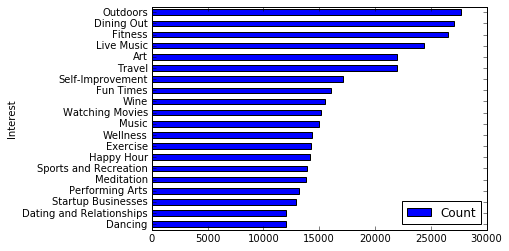

In [4]:
interests = []
c = Counter()
for row in cl_df['topics']:
    user_interests = []
    for interest in row:
        user_interests.append(interest['name'])
    interests.append(user_interests)
    c.update(user_interests)

cl_df.loc[:,'interests'] = interests

counter = pd.DataFrame()
counter['Interest'], counter['Count'] = zip(*c.most_common(20))
counter.sort_index(axis=0 ,ascending=False).plot(x='Interest', kind='barh')

In [5]:
print "There are %s unique interests" % len(c)

There are 21892 unique interests


It would be useful to obtain an histogram showing the number of interests each person has indicated. We create an additional column with this number.

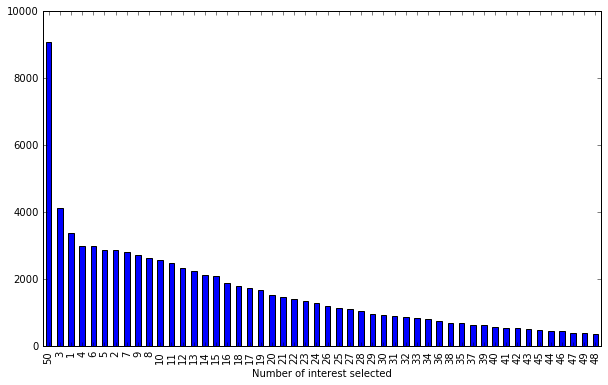

In [6]:
interests_count = []
for row in cl_df['interests']:
    num_of_interests = len(row)
    interests_count.append(num_of_interests)
cl_df.loc[:,'interests_count'] = interests_count
interest_count_plot = cl_df['interests_count'].value_counts().plot(kind='bar', figsize=(10,6))
interest_count_plot.set_xlabel("Number of interest selected")

## Benchmark

We use Gensim as our benchmark solution. See the documentation here: https://radimrehurek.com/gensim/

In [8]:
from gensim import corpora, models, similarities

#Construct dictionary
gensim_dictionary = corpora.Dictionary(cl_df["interests"])

class MyCorpus(object):
    def __len__(self):
        i = 0        
        for line in cl_df["interests"]:
            i += 1
        return i
        
    def __iter__(self):
        for line in cl_df["interests"]:
            yield gensim_dictionary.doc2bow(line)


#print(dictionary)
#gensim_corpus = [dictionary.doc2bow(text) for text in cl_df["interests"]]
gensim_corpus = MyCorpus()

corpora.MmCorpus.serialize('gensim_corpus.mm', gensim_corpus)
gcorpus = corpora.MmCorpus('gensim_corpus.mm')
print "The corpus is ready to be used!"

The corpus is ready to be used!


We create our own function to output the most similar users based on this tutorial: https://radimrehurek.com/gensim/tut3.html

In [9]:
def gensim_similarity(query, match_num = 5):
    vec = gensim_dictionary.doc2bow(cl_df["interests"][query])
    #Modify the path with your own
    index = similarities.Similarity('C:\ML\Captsone project\Capstone', gcorpus, num_features=21892, num_best = match_num)
    sims = index[vec]
    match_list = []
    for guser,gsim in sims:
        #remove the queried user from the match list
        if guser != query:
            match_list.append((guser, gsim))
    return match_list
   
pp.pprint(gensim_similarity(678))

[ (9499, 0.54554486274719238),
  (6280, 0.53665632009506226),
  (74350, 0.53665632009506226),
  (11039, 0.52704644203186035)]


This gives us a list of by default the top 4 tuples containing user index and similarity score ranked in decreasing order of cosine similarity.

# METHODOLOGY
------
## Data preprocessing

We now proceed to extract all the features and vectorize our corpus using TfidfVectorizer which includes a TfidfTransformer. We create a matrix where each row represents a document/user and each column a token/interest.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def my_tokenizer(mylist):
    return mylist

tfidf_vectorizer = TfidfVectorizer(tokenizer = my_tokenizer, lowercase = False)
X = tfidf_vectorizer.fit_transform(x for x in cl_df["interests"])
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 82186, n_features: 21892


## Implementation

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(X, index, match_num = 5):
    """
    Returns the list of top match_num users from X that
    match with index using cosine_similarity.
    """
    sims = cosine_similarity(X[index,:],X)
    # Get the indices that sort the sims array
    sim_list = np.argsort(sims)
    #Reverse and select only the number of matching users indicated by match_num
    sim_list = sim_list[0][::-1][0:match_num+1]
    match_list = []
    #remove the queried user from the match list
    for i in sim_list:
        if i != index:
            match_list.append((i, sims[:,i][0]))
    return match_list

pp.pprint(compute_similarity(X, 4325, match_num=10))

[ (56090, 1.0),
  (55995, 1.0),
  (55774, 0.95236044136229014),
  (17375, 0.95236044136229014),
  (55823, 0.86417102531441214),
  (56001, 0.83555621569324401),
  (17524, 0.81316339861122278),
  (1602, 0.80958605223329849),
  (48407, 0.78371376889767008),
  (55833, 0.75329761507993198)]


In [12]:
def compare_interests(corpus, user_index, match_list, show_interests = 'True'):
    """Compare interests from a list of matching users by printing various information"""
    if show_interests == 'True':
        print "Queried user has {0} interests: {1} \n".format(len(corpus[user_index]), corpus[user_index])
    else:
        print "Queried user has {0} interests".format(len(corpus[user_index]))
    for index, item in enumerate(match_list):
        i, j = item
        shared_interests = set(corpus.loc[user_index]) & set(corpus.loc[i])
        print "Match #{0}".format(index+1)
        print "Match score with {0}: {1}".format(i, j)
        if show_interests == 'True':
            print "Interests of {0}: {1}".format(i, corpus[i])
        print "Number of shared interests: {0} ({1:.00f}% of all {2}'s interests)".format(len(shared_interests),(1.0 * len(shared_interests)/len(corpus[i]))*100, i)
        if show_interests == 'True':
            print "Shared interests: {0} \n".format(shared_interests)
        
        
compare_interests(cl_df["interests"], 4325, compute_similarity(X, 4325, match_num=6))

Queried user has 3 interests: [u'Fitness', u'Vegetarian', u'Vegan'] 

Match #1
Match score with 56090: 1.0
Interests of 56090: [u'Fitness', u'Vegetarian', u'Vegan']
Number of shared interests: 3 (100% of all 56090's interests)
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 

Match #2
Match score with 55995: 1.0
Interests of 55995: [u'Fitness', u'Vegetarian', u'Vegan']
Number of shared interests: 3 (100% of all 55995's interests)
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 

Match #3
Match score with 55774: 0.952360441362
Interests of 55774: [u'Vegan', u'Vegetarian']
Number of shared interests: 2 (100% of all 55774's interests)
Shared interests: set([u'Vegetarian', u'Vegan']) 

Match #4
Match score with 17375: 0.952360441362
Interests of 17375: [u'Vegetarian', u'Vegan']
Number of shared interests: 2 (100% of all 17375's interests)
Shared interests: set([u'Vegetarian', u'Vegan']) 

Match #5
Match score with 55823: 0.864171025314
Interests of 55823: [u'Veget

Logically users with a lower number of interests indicated on their profile are more likely to have a higher matching score with other users because it is easier for other users to share all their interests since they indicated so few.

Though 2 more interesting points appear from the example above:
- The 5th matching user has a score of 0.86, significantly lower than the 3rd and 4th matching users (with a score of 0.95) even though the 5th matching user has all their interests (namely "Vegeterian" and "Vegan"). This means that the algorithm penalizes having additional non-shared interests in terms of similarity. This might be a far-fetched deduction. What if the queried person simply forgot to indicate that she also likes Spirituality? What's more what if the 4th match forgot to indicate that she likes Hiking, which the queried user hates?

- Even more worrisome is the fact that the 6th matching user has all the interests of the queried user but is only in the 6th position after users with only 2 matching interests! This is a poor performance if we take the number of shared interests as a metric to evaluate our algorithm.

## Refinement

Sometimes less is more. We get rid of Tfidfvectorizer to use a simpler CountVectorizer. This solves the flaw mentioned above and now the user who appeared as the 6th matching user ranks 3rd.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(tokenizer = my_tokenizer, lowercase = False)
X_count = count_vectorizer.fit_transform(x for x in cl_df["interests"])
print("n_samples: %d, n_features: %d" % X_count.shape)

n_samples: 82186, n_features: 21892


In [14]:
compare_interests(cl_df["interests"], 4325, compute_similarity(X_count, 4325, match_num=6))

Queried user has 3 interests: [u'Fitness', u'Vegetarian', u'Vegan'] 

Match #1
Match score with 55995: 1.0
Interests of 55995: [u'Fitness', u'Vegetarian', u'Vegan']
Number of shared interests: 3 (100% of all 55995's interests)
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 

Match #2
Match score with 56090: 1.0
Interests of 56090: [u'Fitness', u'Vegetarian', u'Vegan']
Number of shared interests: 3 (100% of all 56090's interests)
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 

Match #3
Match score with 56001: 0.866025403784
Interests of 56001: [u'Fitness', u'Vegetarian', u'Vegan', u'Organic Foods']
Number of shared interests: 3 (75% of all 56001's interests)
Shared interests: set([u'Vegetarian', u'Vegan', u'Fitness']) 

Match #4
Match score with 17375: 0.816496580928
Interests of 17375: [u'Vegetarian', u'Vegan']
Number of shared interests: 2 (100% of all 17375's interests)
Shared interests: set([u'Vegetarian', u'Vegan']) 

Match #5
Match score with 55774: 0.

By randomly exploring suggested similar users, I was puzzled by the fact that some users with more shared interests were still ranked below some others with less shared interests. 
Adding the percentage of shared interests out of all the interests of a given match made me think that the algorithm values whether the shared interests represent a large fraction of all the user's interest or not. 

For example if A and B have an equal number of shared interest with the queried user but those represent respectively 48% of A interests and 53% of B interests. B will rank higher. 
The following example seems to confirm this hypothesis. Match #9 has more interests in common than the 6 users above her, yet the shared interests with the queried user only represents half of her interests as opposed to 70% for Match #5.

In [15]:
import random

#random_user = random.randrange(1,82186, 1)

compare_interests(cl_df["interests"], 14532, compute_similarity(X_count, 14532, match_num=9), show_interests='False')

Queried user has 50 interests
Match #1
Match score with 17118: 0.551487018011
Number of shared interests: 21 (72% of all 17118's interests)
Match #2
Match score with 14688: 0.54
Number of shared interests: 27 (54% of all 14688's interests)
Match #3
Match score with 42747: 0.524631389871
Number of shared interests: 17 (81% of all 42747's interests)
Match #4
Match score with 65267: 0.517597311377
Number of shared interests: 24 (56% of all 65267's interests)
Match #5
Match score with 30137: 0.517114501254
Number of shared interests: 19 (70% of all 30137's interests)
Match #6
Match score with 10492: 0.511489610473
Number of shared interests: 22 (59% of all 10492's interests)
Match #7
Match score with 23618: 0.509116882454
Number of shared interests: 18 (72% of all 23618's interests)
Match #8
Match score with 10813: 0.509116882454
Number of shared interests: 18 (72% of all 10813's interests)
Match #9
Match score with 47181: 0.5
Number of shared interests: 25 (50% of all 47181's interests)


### Changes in Vectorizer parameters

As provided by sklearn's documentation the max_df parameter allows to set a threshold so that when the vocabulary is built, the vectorizer will ignore terms that have a document frequency strictly higher than the given threshold.
In our case setting 1000 which is a low number relative to our dataset as threshold has the effect of discarding the 281 most common interests. Thus, our algorithm now seems to return people matching users based on their most peculiar and uncommon interests... which is something potentially interesting. However this raises the question: are there interests so commonly shared that they can be ignored?

In [16]:
lcount_vectorizer = CountVectorizer(tokenizer = my_tokenizer, lowercase = False, max_df =1000)
X_lcount = lcount_vectorizer.fit_transform(x for x in cl_df["interests"])

print "Number of interests ignored: %d" % len(lcount_vectorizer.stop_words_)
print [k.encode('utf-8') for k in lcount_vectorizer.stop_words_]
print ""

compare_interests(cl_df["interests"], 2306, compute_similarity(X_lcount, 2306, match_num=6))

Number of interests ignored: 281
['Video Games', 'Cycling', 'International Travel', 'Fitness', 'Spanish Language', 'Poetry', 'Arts & Entertainment', 'Boating', "Singles 30's-50's", 'Parents', 'Beauty Industry', 'Pets', 'Watching Movies', 'Comedy', 'Nutrition', 'Gaming', 'Stress Relief', 'Italian Language', 'Weekend Adventures', 'Painting', 'Photography', 'Philosophy', 'Running', 'Entrepreneurship', 'Sustainability', 'Leadership', 'Self Exploration', 'Authors', 'Holistic Health', 'Makeup', 'HTML5', 'Karaoke', 'Nature Photography', 'Single Parents', 'Photography Classes', 'African American Women', 'Small Breed Dogs', 'Craft Beer', 'Weight Loss', 'Mobile Technology', 'Art Walks and Tours', 'Conversation', 'Off-Leash Dog Recreation', 'Wellness', 'Nightlife', 'Bowling', 'Open Source', 'Writing', 'Reiki', 'Web Technology', 'Wine', 'Exercise', 'Art', 'Hiking', 'Animal Welfare', 'Fun and Laughter', 'Cultural Activities', 'Locals & New in Town', 'Learning', 'Creative Writing', 'Education', 'Wom

### Using a different distance metric

In [17]:
from sklearn.metrics.pairwise import euclidean_distances


def compute_euclidean_similarity(X, index, match_num = 5):
    sims = euclidean_distances(X[index,:],X)
    sim_list = np.argsort(sims)
    
    #Reverse and select only the number of matching users indicated by match_num
    sim_list = sim_list[0][0:match_num+1]
    match_list = []
    for i in sim_list:
        #remove the queried user from the match list
        if i != index:
            match_list.append((i, sims[:,i][0]))
    return match_list

euclidean_results = pd.DataFrame(compute_euclidean_similarity(X_count, 4327, match_num=10),
                                 columns=['euclidean match', 'euclidean similarity'])
cosine_results = pd.DataFrame(compute_similarity(X_count, 4327, match_num=10),
                             columns=['cosine match', 'cosine similarity'])


distance_comparison = pd.concat([euclidean_results, cosine_results], axis=1)
distance_comparison.head(n=7)

,euclidean match,euclidean similarity,cosine match,cosine similarity
0,41839,4.242641,41839,0.580259
1,45050,4.358899,65608,0.544331
2,70043,4.358899,45050,0.544331
3,65608,4.358899,70043,0.544331
4,70824,4.472136,28156,0.533761
5,58356,4.472136,27521,0.529813
6,28156,4.472136,27054,0.522233


The 4th first are exactly the same.After the first entry (#41839) they are presented in different orders but the next 3 are technical similar because they have the same score, after that results start to diverge.

In [18]:
compare_interests(cl_df["interests"], 4327, compute_euclidean_similarity(X_count, 4327, match_num=10), show_interests = 'False')
print "--------------"
compare_interests(cl_df["interests"], 4327, compute_similarity(X_count, 4327, match_num=10), show_interests = 'False')

Queried user has 27 interests
Match #1
Match score with 41839: 4.24264068712
Number of shared interests: 10 (91% of all 41839's interests)
Match #2
Match score with 45050: 4.35889894354
Number of shared interests: 8 (100% of all 45050's interests)
Match #3
Match score with 70043: 4.35889894354
Number of shared interests: 8 (100% of all 70043's interests)
Match #4
Match score with 65608: 4.35889894354
Number of shared interests: 8 (100% of all 65608's interests)
Match #5
Match score with 70824: 4.472135955
Number of shared interests: 7 (100% of all 70824's interests)
Match #6
Match score with 58356: 4.472135955
Number of shared interests: 7 (100% of all 58356's interests)
Match #7
Match score with 28156: 4.472135955
Number of shared interests: 10 (77% of all 28156's interests)
Match #8
Match score with 27054: 4.472135955
Number of shared interests: 9 (82% of all 27054's interests)
Match #9
Match score with 35886: 4.472135955
Number of shared interests: 8 (89% of all 35886's interests)
M

Comparing match #8, #9 and #10 shows that using Euclidean distance favors matching users with less matching interests but representing a higher percentage of their total interests which goes against the desired outcome.

# RESULTS
## Model Evaluation & Validation

As a metric to evaluate a model and thus compare the solution model with our benchmark we use a special metric. For a queried user i, we loop through the list of matches and compute the following for each match j:

Number of shared interest between i and j / Number of interests of i

We then look at the average in order to determine if the list contains a high number of people sharing a lot of interests with the queried user; as well as standard deviation.

The following code allows to generate user randomly and set a number of iterations.

In [19]:
def model_evaluation(corpus, model = 'solution', n_iter = 100, match_num = 10):
    avg_metric_list = []
    std_metric_list = []
    t0 = time()
    for i in range(1, n_iter+1):
        user_eval = []
        random_user = random.randrange(1,len(corpus), 1)
        #print "iteration #{0} with user #{1}".format(i,random_user)
        if model == 'solution':
            matching_list = compute_similarity(X_count, random_user, match_num = match_num)
        elif model == 'benchmark':
            matching_list = gensim_similarity(random_user, match_num = match_num)
        for index, item in enumerate(matching_list):
            i, j = item
            shared_interests = set(corpus.loc[random_user]) & set(corpus.loc[i])
            #compute the number of shared interests over the total number of the random user interests
            eval_metric = 1.0 * len(shared_interests) / len(corpus[random_user])
            user_eval.append(eval_metric)
        avg_metric_list.append(np.mean(user_eval))
        std_metric_list.append(np.std(user_eval))
    print("done in %fs" % (time() - t0))    
    print "On average the top {0} recommended users share {1:.2f}% of the queried user's interests".format(match_num,np.mean(avg_metric_list) * 100)  
    print "Average of standard deviations is {0}".format(np.average(std_metric_list))
    
model_evaluation(cl_df['interests'], model = 'solution', n_iter = 10, match_num = 10)

done in 0.883000s
On average the top 10 recommended users share 50.58% of the queried user's interests
Average of standard deviations is 0.0901860264483


Here are some results obtained by running the code above:

Solution model:
- From running several times the code above with samples of 1000 users, on average the top 10 recommended users share about 52% of the queried user's interests, with an average of standard deviations equal to 9%.
- On average the number 1 recommended user shares about 56% of the queried user's interests

Benchmark model (gensim):
- On average the top 10 recommended users share about 55% of the queried user's interests, with an average of standard deviations equal to 9%.

The benchmark model seems to perform a bit better than our solution model in terms of average shared interests.

However something important to consider is processing time:
The benchmark model is able to execute 10 iterations (with a number 10 matching users returned) in 257 seconds as opposed to 0.76 seconds for our solution model!
Maybe our implementation of gensim can be improved to make it faster but as it is now, its speed largely favors our solution model.

Now let's see how our model handles unseen data. 

We first select an existing user randomly (user #246) and take notes of her interests.

In [19]:
selected_user = cl_df['interests'][246]
print "Selected user's interests: %s" % selected_user
compare_interests(cl_df["interests"], 4327, compute_similarity(X_count, 4327, match_num=10), show_interests = 'False')

Selected user's interests: [u'Consciousness', u'Jewish', u'Spirituality', u'Alternative Medicine', u'Meditation', u'Bilingual Spanish/English', u'Philosophy', u'Nature Walks', u'Outdoors', u'Animal Welfare', u'Dog Rescue', u'Pug', u'Small Breed Dogs', u'Art', u'professional-networking']
Queried user has 27 interests
Match #1
Match score with 41839: 0.580258853186
Number of shared interests: 10 (91% of all 41839's interests)
Match #2
Match score with 65608: 0.544331053952
Number of shared interests: 8 (100% of all 65608's interests)
Match #3
Match score with 45050: 0.544331053952
Number of shared interests: 8 (100% of all 45050's interests)
Match #4
Match score with 70043: 0.544331053952
Number of shared interests: 8 (100% of all 70043's interests)
Match #5
Match score with 28156: 0.533760512684
Number of shared interests: 10 (77% of all 28156's interests)
Match #6
Match score with 27521: 0.529812942826
Number of shared interests: 12 (63% of all 27521's interests)
Match #7
Match score w

We then purposefully create a new, fake user who shares a lot of those interests (all except 3) and see if our algorithm place the original user (#246) among the top matches of the fake user.

In [20]:
selected_user = cl_df['interests'][246]
print "Selecteed user's interests: %s" % selected_user


fake_user = [[u'Consciousness',
             u'Jewish',
             u'Spirituality',
             u'Alternative Medicine',
             u'Meditation',
             u'Nature Walks',
             u'Outdoors',
             u'Animal Welfare',
             u'Dog Rescue',
             u'Pug',
             u'Small Breed Dogs',
             u'Art',
             ]]

X_fake = count_vectorizer.transform(fake_user)
validation_sims = cosine_similarity(X_count, X_fake)

validation_sim_list = np.argsort(validation_sims, axis = 0)

#Reverse and select only the number of matching users indicated by match_num
validation_sim_list = validation_sim_list[::-1][0:10+1]
match_list = []
for us in validation_sim_list:
    match_list.append((us[0], validation_sims[us][0][0]))
pp.pprint(match_list)

Selecteed user's interests: [u'Consciousness', u'Jewish', u'Spirituality', u'Alternative Medicine', u'Meditation', u'Bilingual Spanish/English', u'Philosophy', u'Nature Walks', u'Outdoors', u'Animal Welfare', u'Dog Rescue', u'Pug', u'Small Breed Dogs', u'Art', u'professional-networking']
[ (246, 0.89442719099991586),
  (37528, 0.54554472558998102),
  (43095, 0.51639777949432231),
  (44523, 0.50000000000000011),
  (37634, 0.50000000000000011),
  (10712, 0.47140452079103179),
  (28609, 0.47140452079103179),
  (37693, 0.47140452079103179),
  (80818, 0.46358632497276531),
  (17844, 0.43643578047198478),
  (65694, 0.43643578047198478)]


Bingo! User 246 ranks #1 among the matches of our fake user with a similarity score of 89%.

## CONCLUSION
### Free-form Visualization (using Dimensionality Reduction)

Greatly taken from http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

We first try to determine the optimal number of components for LSA.

In [21]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

#hashing_vectorizer = HashingVectorizer(n_features=21892,
#                                       tokenizer=my_tokenizer,
#                                       lowercase = False
#                                       )

#X_hash = hashing_vectorizer.fit_transform(x for x in cl_df["interests"])
#print("n_samples: %d, n_features: %d" % X_hash.shape)

variances = []
n_components_range = [100, 300, 500, 700, 900, 1100]

print("Performing dimensionality reduction using LSA")
for n_components in n_components_range: 
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    
    X_lsa = lsa.fit_transform(X_count)
    
    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD with {0} components: {1}%".format(
        n_components, int(explained_variance * 100)))
    
    lsa_result = (n_components, explained_variance)
    variances.append(lsa_result)
    
print variances

Performing dimensionality reduction using LSA
done in 4.666000s
Explained variance of the SVD with 100 components: 55%
done in 12.692000s
Explained variance of the SVD with 300 components: 77%
done in 37.078000s
Explained variance of the SVD with 500 components: 85%
done in 36.489000s
Explained variance of the SVD with 700 components: 88%
done in 53.334000s
Explained variance of the SVD with 900 components: 89%
done in 91.187000s
Explained variance of the SVD with 1100 components: 89%
[(100, 0.55970633412351545), (300, 0.77245312251094755), (500, 0.85065875136692826), (700, 0.88240962895891761), (900, 0.89092761089992778), (1100, 0.89512944932828309)]


We can now use the "Elbow Method" to determine which number of components we should choose. The chart below seems to show that 500 is the optimal number of components as the marginal explained variance decreases significantly as the number of components exceeds 500.

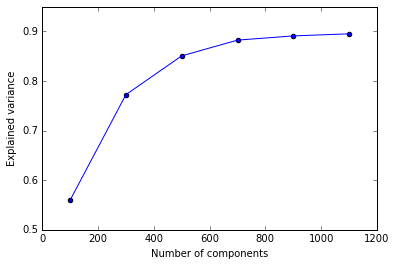

In [22]:
import matplotlib.pyplot as plt
plt.scatter(*zip(*variances))
plt.plot(*zip(*variances))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

Let's apply LSA with 500 components.

In [23]:
print("Performing dimensionality reduction using LSA")
svd = TruncatedSVD(500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_lsa = lsa.fit_transform(X_count)

print("Done. Matrix shape: {}".format(X_lsa.shape))

Performing dimensionality reduction using LSA
Done. Matrix shape: (82186L, 500L)


A good [rule of thumb](https://www.wikiwand.com/en/Determining_the_number_of_clusters_in_a_data_set#Finding_number_of_clusters_in_text_databases) for determining the number of clusters of text documents is given by $(m*n)/t$ where m is the number of documents, n the number of terms and t the number of non-zero entries. In our case this equals to ((82186*21892)/1647034) = 1092 clusters.

The following code takes quite some time.

In [24]:
from sklearn.cluster import KMeans
for k in [800, 1000]:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=10, n_init=1, random_state = 42,
                    verbose=1)

    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(X_lsa)
    print("done in %0.3fs" % (time() - t0))
    print()


    print("Homogeneity: %0.3f" % metrics.homogeneity_score(cl_df["interests"], km.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(cl_df["interests"], km.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(cl_df["interests"], km.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(cl_df["interests"], km.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X_lsa, km.labels_, sample_size=1000))

    print()

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=10, n_clusters=800, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=42, tol=0.0001,
    verbose=1)
Initialization complete
Iteration  0, inertia 71545.797
Iteration  1, inertia 49167.549
Iteration  2, inertia 48280.226
Iteration  3, inertia 47862.665
Iteration  4, inertia 47620.037
Iteration  5, inertia 47467.648
Iteration  6, inertia 47365.060
Iteration  7, inertia 47287.551
Iteration  8, inertia 47230.310
Iteration  9, inertia 47189.137
done in 247.528s
()
Homogeneity: 0.589
Completeness: 1.000
V-measure: 0.741
Adjusted Rand-Index: 0.051
Silhouette Coefficient: 0.256
()
Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=10, n_clusters=1000, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=42, tol=0.0001,
    verbose=1)
Initialization complete
Iteration  0, inertia 69620.892
Iteration  1, inertia 48099.529
Iteration  2, inertia 47226.683
Iteration  3, i

After testing several values for the number of clusters it appears that setting a lower number of clusters decreases all metrics, in particular the Silhouette Coefficient. As it can be seen above going from 800 to 1000 gives a lift to the Silhouette Coefficient.

Now let's find out the top interests among different clusters by using svd.inverse_transform on some random clusters' centers.

In [25]:
print("Top terms per cluster:")

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = count_vectorizer.get_feature_names()
for i in range(1,800, 200):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()

Top terms per cluster:
Cluster 1:
 Self-Improvement
 Business Strategy
 Live Music
 Meditation
 Art
 Professional Development
 Startup Businesses
 Dining Out
 Eating, Drinking, Talking, Laughing, Etc
 Exercise
()
Cluster 201:
 Meditation
 Spirituality
 Energy Healing
 Spiritualism
 Yoga
 Alternative Medicine
 Reiki
 Holistic Health
 Fitness
 Travel
()
Cluster 401:
 Online Marketing
 SEO (Search Engine Optimization)
 Startup Businesses
 Professional Networking
 Technology
 Marketing
 Fitness
 Travel
 Outdoors
 Investing
()
Cluster 601:
 Italian Language
 Italian Culture
 Italiano
 Italian Food
 Travel
 Expat Italian
 Dining Out
 Italian Travel
 Wine
 Happy Hour
()


The result above is very interesting as it shows clustering based on related interests.